<br>
<br>

### Approaching the idea and way of thinking <br>
1) First we need to collect app reviews which would be easier using google-play-scraper library  <br>
2) Explore the collected data to find the most suitable labels needed for classification and preprocessing steps<br>
3) While exploring the reviews content another problem appeared which is that the language might be English , Arabic , Franco-Arab or mix between those so i thought maybe translate all into English i found "franco_arabic_transliterator" library(Franco->Arabic) but didnt work well , as already the collected data was huge i decided to omit arabic reviews also tried to detect the language to omit any franco until creating more efficient Franco->Arabic translator but mostly didnt work well so i labeled some franco reviews till finding better approach.<br>
4) Data correction for example score vs review content: wrong scoring 1 or 2 when the review content positive solution and vice versa solution for that either to be considered  misleading content so drop those rows , edit the score according to review content as its the most likely right or leave it as its i choosed the last option.<br>

Note: i only worked on android "google play" to be easier to label manually , All the steps should be the same with IOS using similar library to collect reviews but will need more samples labeling 

#### 1. Import required packages

In [528]:

import json
# csv to deal with files
import csv
import string
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np
import fasttext
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
#==============================
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
#==============================
from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

import os
from natsort import natsorted
from google_play_scraper import Sort, reviews, reviews_all

#https://stackoverflow.com/questions/47489836/convert-emoji-unicode-to-text-in-python
#https://github.com/NeelShah18/emot
#https://emot.readthedocs.io/en/latest/
from emot.emo_unicode import UNICODE_EMOJI, UNICODE_EMOJI_ALIAS, EMOTICONS_EMO
from emoji import UNICODE_EMOJI
from flashtext import KeywordProcessor

from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize


# Natural Language Processing
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

#### 2. Collect the data:
##### Will be using : https://github.com/JoMingyu/google-play-scraper
https://www.linkedin.com/pulse/how-scrape-google-play-reviews-4-simple-steps-using-python-kundi/

https://github.com/prakharrathi25/Text-Analytics-Tool/blob/main/Notebooks/sentiment_analysis_data_collection.ipynb

https://www.kaggle.com/prakharrathi25/google-play-store-reviews

https://www.kaggle.com/therealsampat/scraping-google-play-app-reviews/notebook

#### 2.1 Scrape Google Play Reviews:
Install All the needed backages using pip install (The ! notation to run directly as a shell command from the notebook)

##### Step 1: Download and Install Google Play Scraper Package and required packages 
Ways of scrap data (beautiful soup , mechanical soup , selenium ..etc) <br>
https://github.com/abdallahash/cars_scrape/blob/master/scrape_data.py <br>
https://github.com/MariyaSha?tab=repositories <br>
https://colab.research.google.com/drive/1bZuM6y36l6-Ukq7iE7HJOCrGz3Btw0-2?usp=sharing#scrollTo=TlN9KywdOKYA

##### Step 2: Find the App Id in Google Play Store:

URL: https://play.google.com/store/apps/details?id=com.emeint.android.myservices&hl=en&gl=US <br>ID= com.emeint.android.myservices

##### Step 3: Scrape the Reviews using Google Play Scraper then put the Reviews into Pandas DataFrame to work on

In [ ]:
# Collect the data from google play 
#To check if the file exist or not using os 
#If exist get first 10 reviews to compare reviewId to the collected and stored data
if os.path.isfile('AnaVodafone_Android_Reviews.csv') == True:
    #Reading CSV stored data into dataframe
    app_reviews_df = pd.read_csv("AnaVodafone_Android_Reviews.csv")#AnaVodafoneReviews.csv")
    app_reviews_df = pd.DataFrame(app_reviews_df)
    #Getting the first 10 reviews from google play
    result, continuation_token = reviews(
    'com.emeint.android.myservices',
    lang='en', # defaults to 'en'
    country='us', # defaults to 'us'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
    count=10, # defaults to 100
    filter_score_with=None # defaults to None(means all score)
    )
    ##creating new dataframe named Total_App_Reviews_df to hold all the new and append the old data into it
    Total_App_Reviews_df = pd.DataFrame(result)
    NewReviewsID=Total_App_Reviews_df['reviewId']
    m=app_reviews_df.loc[app_reviews_df['reviewId'].isin(NewReviewsID)] 
    while m.empty==True:
        #Get the next 10 Reviews 
        result, _ = reviews(
        'com.emeint.android.myservices',
        continuation_token=continuation_token # defaults to None(load from the beginning)
       )
        New_App_Reviews_df = pd.DataFrame(result)
        NewReviewsID=New_App_Reviews_df['reviewId']
        #To select rows whose column value is in an iterable array, which we'll define as array, you can use isin:
        m=app_reviews_df.loc[app_reviews_df['reviewId'].isin(NewReviewsID)]
        #ignore_index=True used to get rid of duplicates using "drop_duplicates()" 
        #as if indices exist it will not be considered equal as the appended will be start with zero 
        Total_App_Reviews_df = Total_App_Reviews_df.append(pd.DataFrame(result),ignore_index = True)
    Total_App_Reviews_df = Total_App_Reviews_df.append(app_reviews_df,ignore_index = True)
    ##Drop duplicates woudnt work as there is a time colums 
    #https://stackoverflow.com/questions/46489695/drop-duplicates-not-working-in-pandas
    #Total_App_Reviews_df.drop_duplicates(inplace=True)
    #Total_App_Reviews_df = Total_App_Reviews_df[~Total_App_Reviews_df.index.duplicated()]
    #Total_App_Reviews_df = Total_App_Reviews_df.astype('str')
    Total_App_Reviews_df=Total_App_Reviews_df.drop_duplicates(subset='reviewId')#, keep='first'#, inplace=True)#, ignore_index=True)
    ##Storing the collected total reviews data into the csv file with the same name "replace the old one"
    Total_App_Reviews_df.to_csv('Temp.csv',mode='w', index=None, header=True)
  
    
else:
    
    #Get all the review and save them into csv file
    result = reviews_all(
        'com.emeint.android.myservices',
        sleep_milliseconds=0, # defaults to 0
        lang='en', # defaults to 'en'
        country='eg', # defaults to 'us'
        sort=Sort.NEWEST#MOST_RELEVANT, # defaults to Sort.MOST_RELEVANT
        #filter_score_with=Filter_Review_Score # defaults to None(means all score)
        )
    Total_App_Reviews_df = pd.DataFrame(result)
    Total_App_Reviews_df.to_csv('AnaVodafone_Android_Reviews.csv', index=None, header=True)



In [ ]:

# To remove the old file if exist then rename temp file.
if os.path.isfile('AnaVodafone_Android_Reviews.csv') == True:
    os.remove('AnaVodafone_Android_Reviews.csv')
os.rename(r'Temp.csv',r'AnaVodafone_Android_Reviews.csv')

#### 3. Exploratory Data Analysis 

In [529]:
# For All the collected data.
# Read the stored file
Total_App_Reviews_df = pd.read_csv("AnaVodafone_Android_Reviews.csv")
# Display info 
Total_App_Reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82907 entries, 0 to 82906
Data columns (total 10 columns):
at                      82907 non-null object
content                 82901 non-null object
repliedAt               31129 non-null object
replyContent            31129 non-null object
reviewCreatedVersion    75589 non-null object
reviewId                82907 non-null object
score                   82907 non-null int64
thumbsUpCount           82907 non-null int64
userImage               82907 non-null object
userName                82907 non-null object
dtypes: int64(2), object(8)
memory usage: 3.8+ MB


##### As below the collected data have 10 columns, 4 out of 10 will be needed for App analysis  

In [530]:
# Display columns header 
Total_App_Reviews_df.columns

Index(['at', 'content', 'repliedAt', 'replyContent', 'reviewCreatedVersion',
       'reviewId', 'score', 'thumbsUpCount', 'userImage', 'userName'],
      dtype='object')

In [531]:
Total_App_Reviews_df.describe()

,score,thumbsUpCount
count,82907.000000,82907.000000
mean,3.818085,0.334085
std,1.642280,5.247766
min,1.000000,0.000000
25%,2.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,434.000000


As the info below replyContent , replyAt and reviewCreatedVersion have alot of missing values that doesn't cause any problem except when i try to filter based on version so we can either drop rows with empty "reviewCreatedVersion" column or fill the missing ones with the most appeared version within the same period (day,month..etc), I choosed the first option <br>
Only 6 content column cells empty will be removed too 

In [532]:
# Check count of null values of each column 
Total_App_Reviews_df.isnull().sum()

at                          0
content                     6
repliedAt               51778
replyContent            51778
reviewCreatedVersion     7318
reviewId                    0
score                       0
thumbsUpCount               0
userImage                   0
userName                    0
dtype: int64

In [533]:
#Counting the number of total reviews with score equal to 5
(Total_App_Reviews_df.score==5).sum()

48910

In [534]:
#Counting the number of total reviews with score equal to 1
(Total_App_Reviews_df.score==1).sum()

17911

In [535]:
# Multiple ways to confirm that no empty or missing value exist 
Total_App_Reviews_df = pd.DataFrame(Total_App_Reviews_df)
df = Total_App_Reviews_df[Total_App_Reviews_df.reviewCreatedVersion != 'None']
df_Versions = df[df.reviewCreatedVersion != 'nan']
df_Versions = df_Versions[df_Versions.reviewCreatedVersion != 'NaN']

In [536]:
Total_App_Reviews_df.reviewCreatedVersion.value_counts() #Length: 143 different versions + 1 nan

6.7.3       3842
6.7.5       3710
2020.4.3    2942
6.6.5       2532
2021.8.3    2252
            ... 
19.10.1        2
2021.4.1       2
3.1.21         1
3.1.17         1
3.1.22         1
Name: reviewCreatedVersion, Length: 144, dtype: int64

In [537]:
Total_App_Reviews_df.reviewCreatedVersion.unique() # All the unique 143 versions + 1 nan

array(['2022.2.1.1', '2021.12.2', '2021.2.4', '2022.1.2.3', nan,
       '2022.1.2.1', '2019.11.2', '2021.6.3', '2021.11.1.1', '2021.12.1',
       '2022.1.2.2', '2021.8.3', '2021.6.1.1', '2020.7.1', '2020.6.1',
       '2021.9.1.4', '2021.8.1.1', '2020.8.2', '2021.3.2.1', '2019.11.1',
       '2021.9.1.2', '2021.7.1', '2021.11.1', '2021.3.1', '2020.4.3',
       '2020.10.1', '2022.1.2', '2020.11.1', '2020.1.1', '2021.6.2',
       '6.5.8', '2021.4.2', '2020.6.2', '2020.4.1', '6.7.3', '2019.10.4',
       '6.6.3', '2020.12.1', '2019.11.3', '5.10', '2021.2.1', '2020.2.2',
       '6.5.7', '2020.2.1', '5.12', '2021.8.2', '2021.5.1', '2020.11.2',
       '2021.5.2', '6.7.0', '6.7.5', '2021.1.1', '6.6.2', '2020.9.2',
       '2020.9.1', '2020.8.1', '6.4', '5.6.4', '19.10.2', '2021.4.3',
       '6.6.5', '2020.3.3', '2021.2.2', '6.5.1', '2021.4.1.1', '2021.9.1',
       '5.6.2', '2021.9.1.3', '6.6.6', '6.5.5', '6.5.4', '5.9.3', '6.5.2',
       '6.7.1', '2020.3.2', '5.13', '6.5', '2020.1.2', '5.10.1', '

In [538]:
Total_App_Reviews_df.reviewCreatedVersion.nunique()

144

In [539]:
Total_App_Reviews_df.head(4)

,at,content,repliedAt,replyContent,reviewCreatedVersion,reviewId,score,thumbsUpCount,userImage,userName
0,2022-03-06 12:35:26,Excellent,NaN,NaN,2022.2.1.1,gp:AOqpTOFMdlyetMnJqXM06TeVh-MhEPPXpw_UUlBT7tJ...,5,0,https://play-lh.googleusercontent.com/a-/AOh14...,Hassan Shehab
1,2022-03-06 12:32:58,Your app is bot compatible with bigger fonts f...,NaN,NaN,2021.12.2,gp:AOqpTOEr6k8ftjluY8LQaRdpVO-R-S6xkBpGbhW-_bV...,1,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Tony Hanna
2,2022-03-06 12:32:55,Very bad Service and also The customer Service...,NaN,NaN,2022.2.1.1,gp:AOqpTOEa1QXOHCdDg5Ts2aT4bz2iKlGVvPVetfNNArH...,1,0,https://play-lh.googleusercontent.com/a-/AOh14...,Hesham el Anwar
3,2022-03-06 12:29:29,ف تأخير ف استلام الرقم السري ف خدمة فودافون كا...,2022-03-06 12:32:24,شكرا لمشاركتنا تجربتك ونأسف لكونها غير مرضية. ...,2022.2.1.1,gp:AOqpTOFwE8p64cu_D5GZENOz4D12ZmYYPUpxZ2A-_ZJ...,1,0,https://play-lh.googleusercontent.com/a-/AOh14...,sabroow


In [540]:
Total_App_Reviews_df.tail(4) #Last 4 Rows

,at,content,repliedAt,replyContent,reviewCreatedVersion,reviewId,score,thumbsUpCount,userImage,userName
82903,2011-07-18 19:19:12,"Mini call ""feature"" is very annoying..uninstal...",NaN,NaN,3.0.68,lg:AOqpTOEJrPbvWXE3TeKteydigYmhKhmn2d3CpyF-RQT...,3,2,https://play-lh.googleusercontent.com/EGemoI2N...,A Google user
82904,2011-06-24 13:41:53,Everything in one place really awesome,NaN,NaN,3.0.62,lg:AOqpTOGjaENH8H-dV4gWsFOmaj7MHOadfK177VDmZr_...,5,0,https://play-lh.googleusercontent.com/EGemoI2N...,A Google user
82905,2011-06-23 19:25:16,Great app .. waiting for the self-services,NaN,NaN,3.0.62,lg:AOqpTOFShR5odMx-HaUBQnHFf59qqDRmpwfSb60nDoW...,5,0,https://play-lh.googleusercontent.com/EGemoI2N...,A Google user
82906,2011-06-23 19:18:55,"Great, this version fixed many force-closes!",NaN,NaN,3.0.62,lg:AOqpTOG_9FL6dBVkp6o-5QZrqmdHEz3JevuP9xP-4l-...,5,0,https://play-lh.googleusercontent.com/EGemoI2N...,A Google user


In [541]:
# 4 columns will be used in this analysis (at,content,reviewCreatedVersion,score)
#reviewId unqiue value can be used too but not needed.
Total_App_Reviews_df=Total_App_Reviews_df[["at", "content","reviewCreatedVersion","score"]]

In [542]:
Total_App_Reviews_df['content'] = Total_App_Reviews_df['content'].str.lower()

In [543]:
Total_App_Reviews_df['content'] = Total_App_Reviews_df['content'].str.replace('log in','login')
Total_App_Reviews_df['content'] = Total_App_Reviews_df['content'].str.replace('adsl','dsl')

In [545]:
# First way to sort based on natural sort "Versions sorting"
# another way using natsorted(Total_App_Reviews_df['reviewCreatedVersion'])
#https://stackoverflow.com/questions/2574080/sorting-a-list-of-dot-separated-numbers-like-software-versions
#https://stackoverflow.com/questions/64113271/how-to-pandas-sort-a-dataframe-that-has-one-of-the-columns-as-version-numbers

df_Versions = Total_App_Reviews_df.dropna(subset=['reviewCreatedVersion'])
from distutils.version import LooseVersion
df_Versions_Sorted = df_Versions.iloc[df_Versions['reviewCreatedVersion'].apply(LooseVersion).argsort()].reset_index(drop=True)

In [546]:
#Sort app versions "Length: 75589 means the rest of 82907 reviews have a nan value "undefined"
df_Versions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75589 entries, 0 to 82906
Data columns (total 4 columns):
at                      75589 non-null object
content                 75583 non-null object
reviewCreatedVersion    75589 non-null object
score                   75589 non-null int64
dtypes: int64(1), object(3)
memory usage: 2.0+ MB


In [547]:
Total_App_Reviews_df['content'].str.count('login').sum()
### Another way of counting "login" in each row by creating list that holds each row count of login if needed.
#list(map(lambda x: str(x).count("login"), Total_App_Reviews_df['content']))

680.0

In [548]:
Total_App_Reviews_df['content'].str.count('dsl').sum()

1026.0

In [550]:
#10 most comman words with count not helpfull before preprocessing
from collections import Counter
Counter(" ".join(Total_App_Reviews_df['content'].astype(str)).split()).most_common(10)

[('good', 19364),
 ('very', 11420),
 ('app', 11208),
 ('the', 9907),
 ('and', 8496),
 ('i', 7982),
 ('to', 7394),
 ('it', 6964),
 ('is', 4801),
 ('جدا', 4329)]

In [551]:
#Get the most 10 reviews
Total_App_Reviews_df['content'].value_counts().head(10)

good         8390
very good    3028
excellent    1614
good app     1547
ممتاز        1448
nice         1424
great         698
جيد           623
رائع          596
nice app      557
Name: content, dtype: int64

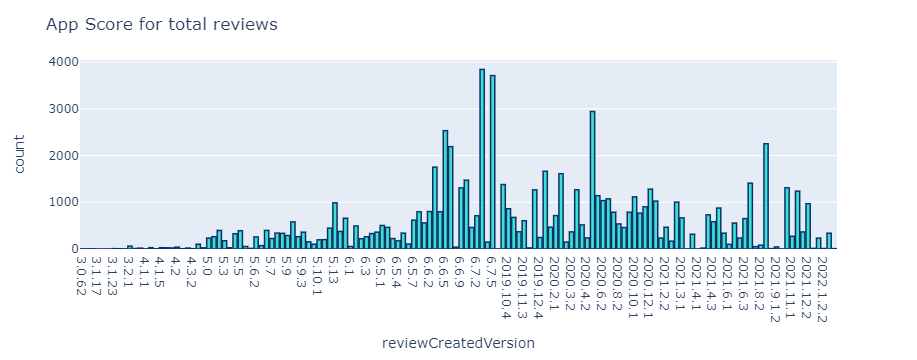

In [606]:
def Draw_Figure1(dataFrame,xColumnName,figureTitle):
    fig = px.histogram(dataFrame, x=xColumnName)
    fig.update_traces(marker_color="turquoise",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
    fig.update_layout(title_text=figureTitle)
    fig.show()
    
    
def Bar_Plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)    
    
Draw_Figure1(df_Versions_Sorted,"reviewCreatedVersion",'App Score for total reviews')

In [553]:
Year_2022_Reviews=Total_App_Reviews_df.loc[(Total_App_Reviews_df['at'] >="2021-12-31 23:59:59")] #& (Total_App_Reviews_df['column_name'] <= B)]

In [15]:
#Year_2022_Reviews.to_csv('Year_2022_Reviews.csv',mode='w', index=None, header=True)

In [36]:
#Year_2022_Reviews['Login']=list(map(lambda x: str(x).count("login"), Year_2022_Reviews['content']))
#Year_2022_Reviews.Login.sum()

30

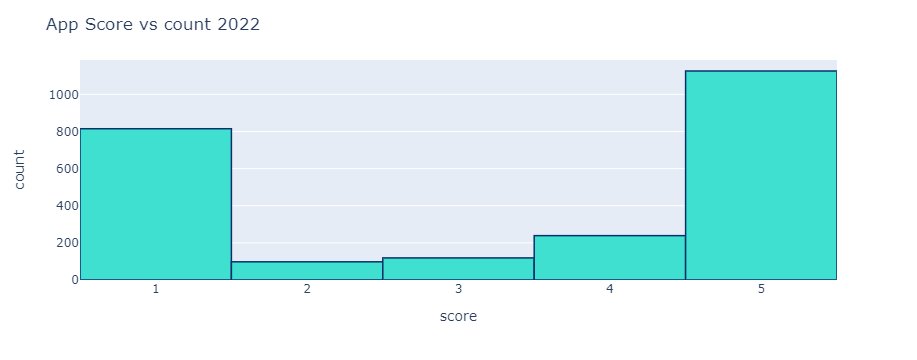

In [607]:
Draw_Figure1(Year_2022_Reviews,"score",'App Score vs count 2022')

In [555]:
Year_2021_Reviews=Total_App_Reviews_df.loc[(Total_App_Reviews_df['at'] >="2020-12-31 23:59:59") & (Total_App_Reviews_df['at'] <= "2021-12-31 23:59:59")]

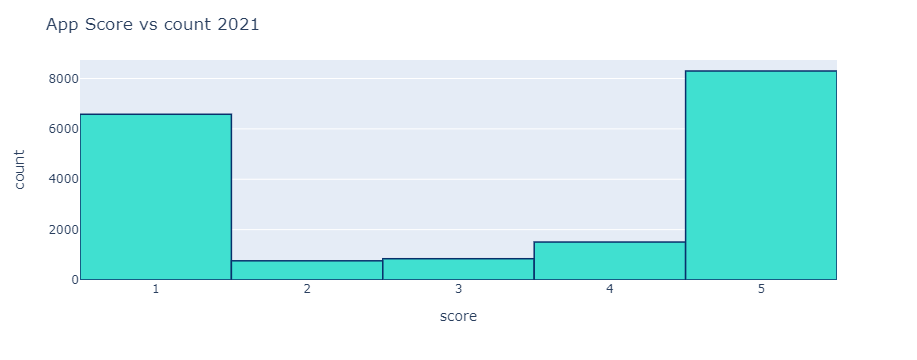

In [556]:
Draw_Figure1(Year_2021_Reviews,"score",'App Score vs count 2021')

In [557]:
Year_2020_Reviews=Total_App_Reviews_df.loc[(Total_App_Reviews_df['at'] >="2019-12-31 23:59:59") & (Total_App_Reviews_df['at'] <= "2020-12-31 23:59:59")]

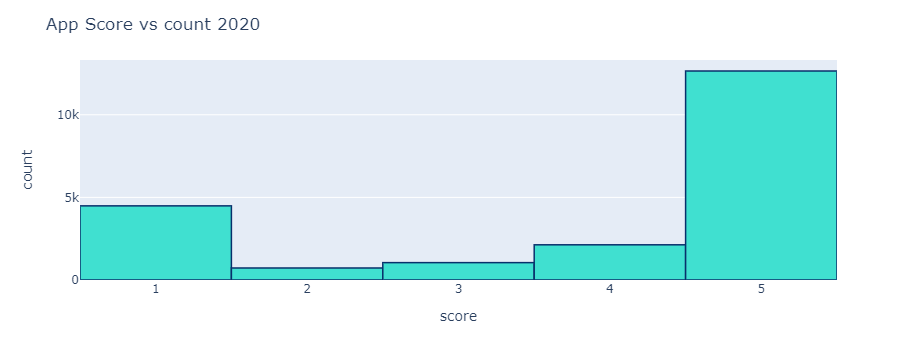

In [558]:
Draw_Figure1(Year_2020_Reviews,"score",'App Score vs count 2020')

##### Next the reviews needed to be cleaned to work on accordingly first we need to get english reviews (franco wouldnt be removed)
##### After collecting the data , randomly i toke some samples(English and emo) and remove any duplicate content to classify the same text only once  

In [322]:
# The below will be used to get english text
#=======================================================================================================
# By selecting only the first letter check if that english letter, the below will fail when the text mixed
# using preprocessing will eliminate any arabic letters 
#=======================================================================================================
def Check_English_Text(dataframe):
    reg = re.compile(r'[a-zA-Z]')
    if reg.match(dataframe):
        return dataframe
Total_App_Reviews_df['OneLetter'] = Total_App_Reviews_df['content'].str[:1]
Total_App_Reviews_df['OneLetter']= Total_App_Reviews_df['OneLetter'].astype(str).apply(lambda text: Check_English_Text(text))

In [325]:
df = Total_App_Reviews_df[Total_App_Reviews_df['OneLetter'].notna()]

In [330]:
# Saveing into "English_Reviews.csv" 
df=df.drop("OneLetter", axis=1)
df
df.to_csv('English_Reviews.csv',mode='w', index=None, header=True)

In [141]:
#================================================================================================
# Remove any non english letters , emoji/emotion and punctuation by replacing them with empty space.
#================================================================================================
def Clean_NonEnglish_Text(dataframe):
    dataframe = re.sub("[^a-zA-Z]", " ", dataframe) 
    return dataframe
#Total_App_Reviews_df['Text1'] = Total_App_Reviews_df['content'].astype(str).apply(lambda text: Clean_NonEnglish_Text(text))
#========================================================
# Another way to remove Emojis and arabic letters
#========================================================
#https://stackoverflow.com/questions/57514169/how-can-i-remove-emojis-from-a-dataframe/57514515#57514515
Total_App_Reviews_df['englishReviews']=Total_App_Reviews_df['content'].astype(str).apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))

 Functiobs to deal with emo/emoticons: 

In [559]:
# The below will be used for both get the emo/emocticons and converting them into words.
#=======================================================================================================
# 1. Creating dictionary all_emoji_emoticons hold all the emojis/emoticons as key , meaning as value
# 2. Using flashtext to process faster than using re
#=======================================================================================================
#https://stackoverflow.com/questions/47489836/convert-emoji-unicode-to-text-in-python
#https://github.com/NeelShah18/emot
#https://emot.readthedocs.io/en/latest/
#from emot.emo_unicode import UNICODE_EMOJI, UNICODE_EMOJI_ALIAS, EMOTICONS_EMO
#from flashtext import KeywordProcessor

all_emoji_emoticons = {**EMOTICONS_EMO,**UNICODE_EMOJI_ALIAS, **UNICODE_EMOJI_ALIAS}
all_emoji_emoticons = {k:v.replace(":","").replace("_"," ").strip() for k,v in all_emoji_emoticons.items()}

kp_all_emoji_emoticons = KeywordProcessor()
for k,v in all_emoji_emoticons.items():
    kp_all_emoji_emoticons.add_keyword(k, v)

In [560]:
#=======================================
#Change Emoji/Emoticons into words
#=======================================
# 1. Adding space before and after to avoid replacing some and not all the Emoji/Emotions into words
# Example ❤️💖💖💖💖💖 -> heart️sparkling heart💖sparkling heart💖sparkling heart if we dont add space.
#=========================================================================================================
def Add_Space(text):
    return ''.join(' ' + char + ' ' if char in all_emoji_emoticons else char for char in text).strip()
#=========================================================================================================
# 2. Replacing each emo into word
#Flashtext will face an issue with combined unicode chars "IndexError: string index out of range"
#alternative packages :pyahocorasick , cyac or replace keyword.py with https://github.com/vi3k6i5/flashtext/pull/82
#=========================================================================================================
def Emo_To_Word(Sentense):
    return kp_all_emoji_emoticons.replace_keywords(Sentense)
#https://towardsdatascience.com/apply-and-lambda-usage-in-pandas-b13a1ea037f7
##Reviews_Content=Total_App_Reviews_df['content'].astype(str).apply(lambda x: Add_Space(x))
#https://medium.com/edureka/python-lambda-b84d68d449a0
#TypeError: object of type 'float' has no len()
##Reviews_Content=Reviews_Content.apply(lambda x: Emo_To_Word(x))

In [212]:
Reviews_Content[47]

'heart ️ sparkling heart  sparkling heart  sparkling heart  sparkling heart  sparkling heart'

In [248]:
# First way to collect Emo the output save and labeled into df-EmoLabeled.csv
#===============================================================
# Only created to be added as training and testing data.
#===============================================================

def split(word):
    return [char for char in word]
#check if the passed exist into all_emoji_emoticons
def Is_Emo(s):
    if s in all_emoji_emoticons:
        return s
#First_In_Content=Total_App_Reviews_df['OneLetter']
#Total_App_Reviews_df['Emo']= First_In_Content.apply(lambda text: Is_Emo(text))

In [339]:
# Another way to collect emo only 
#==============================================================================
# 1. Using Get_Emo to omit any english/arabic/space 
# 2. Using remove_punctuation 
# 3. Using Add_Space to be able to separate between emo.
# 4. Using Counter to get most common , can be saved into csv then classify
#==============================================================================
def Get_Emo(dataframe):
    #Removing English alphabet
    dataframe = re.sub("[a-zA-Z]", "", dataframe) 
    #Removing Arabic alphabet
    dataframe = re.sub('[u0600-\u06ff\u0750-\u077f\ufb50-\ufbc1\ufbd3-\ufd3f\ufd50-\ufd8f\ufd50-\ufd8f\ufe70-\ufefc\uFDF0-\uFDFD]+', "", dataframe)
    dataframe = re.sub(" ","",dataframe)
    dataframe = re.sub("’","",dataframe)
    dataframe = re.sub("‘","",dataframe)
    return dataframe
Total_App_Reviews_df['contentEmo']=Total_App_Reviews_df['content'].astype(str).apply(lambda x: Get_Emo(x))
Total_App_Reviews_df['contentEmoClean']=Total_App_Reviews_df['contentEmo'].astype(str).apply(lambda x: remove_punctuation(x))
Total_App_Reviews_df['contentEmoClean']=Total_App_Reviews_df['contentEmoClean'].astype(str).apply(lambda x: Add_Space(x))
from collections import Counter
Counter(" ".join(Total_App_Reviews_df['contentEmoClean'].astype(str)).split()).most_common(10)

[('👍', 2203),
 ('❤', 2131),
 ('️', 1828),
 ('😍', 1026),
 ('👌', 822),
 ('♥', 759),
 ('👎', 455),
 ('😡', 310),
 ('😂', 270),
 ('💙', 258)]

#### 4. Feature Engineering:
##### The next step is to create features from the raw text so we can train the machine learning models. The steps followed are:

##### Text Cleaning and Preparation as below:
https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing/notebook<br>
4.1 First converting all emoji/emoticons into words using both Add_Space() and Emo_To_Word() so noting will be lost when removing arabic letters. <br>
4.2 Convert all the letters into lowercase <br>
4.3 Remove Arabic letters <br>
4.4 Remove punctuation <br>
4.5 Replace log in with login , adsl to dsl. <br>
4.6 reduce lengthening (EX: finalllly ->finally) <br>
4.7 Tokenization <br>
4.8 Remove stop words <br>
4.9 Stemming <br>
4.10 Lemmatization <br>
##### Label coding: creation of a dictionary to map each category to a code. 
Our Data have 2 created columns first column "label" for sentiment <br>
0 positive <br>
1 negative <br>
2 neutral <br>
3 unrelated to the app or mainly directed about different topic/problem <br>
The second one for extra information if exist <br>
0 no extra info <br>
1 there is extra info: suggestion/hope/wish , specifying issue or concern <br>
##### Train-test split: to test the models on unseen data. 
##### Text representation: use of TF-IDF vs CountVectorizer scores to represent text.
TfidfVectorizer and CountVectorizer both are methods for converting text data into vectors as model can process only numerical data. <br>
https://towardsdatascience.com/representing-text-in-natural-language-processing-1eead30e57d8#:~:text=The%20most%20common%20techniques%20are,semantics%20(Word2vec%2C%20GloVe).

##### Preprocessing other functions:

In [561]:
#================================================================================================
# Used to reduce lengthening of any text that have repeated letters Ex: Reallllly -> Really 
#================================================================================================
#import re
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)
#Total_English_ReviewsLast3Years["contentN"] = Total_English_ReviewsLast3Years["content"].astype(str).apply(lambda text: reduce_lengthening(text))

In [562]:
#=====================================
# Used to remove the punctuation
#=====================================
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
#Total_App_Reviews_df['CleanText'] = Total_App_Reviews_df['TextLowerCase'].astype(str).apply(lambda text: remove_punctuation(text))
#Total_App_Reviews_df.head()

In [26]:
Total_App_Reviews_df['CleanText'].unique()

array(['                 ', 'ga', 'excellent app', ...,
       'everything in one place really awesome',
       'great app  waiting for the selfservices',
       'great this version fixed many forcecloses'], dtype=object)

In [563]:
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

#### Applying all the preprocessing steps on labeled data:

In [565]:
# Reading the stored labeled data to work on it
Samples = pd.read_csv("Labeled_Data.csv")
Samples = pd.DataFrame(Samples)

In [566]:

#4.1 First converting all emoji/emoticons into words 
#using both Add_Space() and Emo_To_Word() so emoji/emoticons will be lost when removing arabic letters. 
Samples['contentAS']=Samples['content'].astype(str).apply(lambda x: Add_Space(x))
Samples['contentETW']=Samples['contentAS'].apply(lambda x: Emo_To_Word(x))
#================================================================================================================
#4.2 Convert all the letters into lowercase 
Samples['contentLW'] = Samples['contentETW'].str.lower()
#================================================================================================================
#4.3 Remove Arabic letters 
## Remove Emojis and arabic letters
#=====================================================
#https://stackoverflow.com/questions/57514169/how-can-i-remove-emojis-from-a-dataframe/57514515#57514515
Samples['contentNA']=Samples['contentLW'].astype(str).apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
#================================================================================================================
#4.4 Remove punctuation 
Samples['contentClean'] = Samples['contentNA'].astype(str).apply(lambda text: remove_punctuation(text))
#================================================================================================================
#4.5 Replace log in with login , adsl to dsl
Samples['contentClean'] = Samples['contentClean'].str.replace('log in','login')
Samples['contentClean'] = Samples['contentClean'].str.replace('adsl','dsl')
#================================================================================================================
#4.6 reduce lengthening (EX: finalllly ->finally) 
Samples['contentRL'] = Samples['contentClean'].astype(str).apply(lambda text: reduce_lengthening(text))
#================================================================================================================
#4.7 Tokenization 
Samples['TokenWords']=Samples['contentRL'].astype(str).apply(word_tokenize)
#================================================================================================================
#4.8 Remove stop words 
stop_words = set(stopwords.words('english'))
Samples['TokenWordsStop']=Samples['TokenWords'].apply(lambda x: [item for item in x if item not in stop_words])
#================================================================================================================
#4.9 Stemming 
stemmer = PorterStemmer()
Samples["Text_Stemmed"] = Samples['TokenWordsStop'].astype(str).apply(lambda text: stem_words(text))
#================================================================================================================
#4.10 Lemmatization 
lemmatizer = WordNetLemmatizer()
Samples["Text_Lemmatized"] = Samples['Text_Stemmed'].astype(str).apply(lambda text: lemmatize_words(text))


Samples.head(5)

,at,content,repliedAt,replyContent,reviewCreatedVersion,reviewId,score,thumbsUpCount,userImage,userName,...,contentAS,contentETW,contentLW,contentNA,contentClean,contentRL,TokenWords,TokenWordsStop,Text_Stemmed,Text_Lemmatized
0,2022-03-06 12:35:26,excellent,NaN,NaN,2022.2.1.1,gp:AOqpTOFMdlyetMnJqXM06TeVh-MhEPPXpw_UUlBT7tJ...,5,0,https://play-lh.googleusercontent.com/a-/AOh14...,Hassan Shehab,...,excellent,excellent,excellent,excellent,excellent,excellent,[excellent],[excellent],['excellent'],['excellent']
1,2022-03-06 12:32:58,your app is bot compatible with bigger fonts f...,NaN,NaN,2021.12.2,gp:AOqpTOEr6k8ftjluY8LQaRdpVO-R-S6xkBpGbhW-_bV...,1,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Tony Hanna,...,your app is bot compatible with bigger fonts f...,your app is bot compatible with bigger fonts f...,your app is bot compatible with bigger fonts f...,your app is bot compatible with bigger fonts f...,your app is bot compatible with bigger fonts f...,your app is bot compatible with bigger fonts f...,"[your, app, is, bot, compatible, with, bigger,...","[app, bot, compatible, bigger, fonts, elder, p...","['app', 'bot', 'compatible', 'bigger', 'fonts'...","['app', 'bot', 'compatible', 'bigger', 'fonts'..."
2,2022-03-06 12:32:55,very bad service and also the customer service...,NaN,NaN,2022.2.1.1,gp:AOqpTOEa1QXOHCdDg5Ts2aT4bz2iKlGVvPVetfNNArH...,1,0,https://play-lh.googleusercontent.com/a-/AOh14...,Hesham el Anwar,...,very bad service and also the customer service...,very bad service and also the customer service...,very bad service and also the customer service...,very bad service and also the customer service...,very bad service and also the customer service...,very bad service and also the customer service...,"[very, bad, service, and, also, the, customer,...","[bad, service, also, customer, service, unders...","['bad', 'service', 'also', 'customer', 'servic...","['bad', 'service', 'also', 'customer', 'servic..."
3,2022-03-06 12:25:14,very bad,2022-03-06 12:32:37,What is the problem that you face ?,2022.2.1.1,gp:AOqpTOEY2n7WVbHw28WIQax30WvtO5vOpAmAS-rNkYo...,1,0,https://play-lh.googleusercontent.com/a-/AOh14...,ahmed kedwany,...,very bad,very bad,very bad,very bad,very bad,very bad,"[very, bad]",[bad],['bad'],['bad']
4,2022-03-06 12:20:45,very good app,NaN,NaN,2022.2.1.1,gp:AOqpTOGAcWxqmgUWZRiVRnap6dgsyhlAoy-h_YCD2VH...,5,0,https://play-lh.googleusercontent.com/a-/AOh14...,khaled mohamed,...,very good app,very good app,very good app,very good app,very good app,very good app,"[very, good, app]","[good, app]","['good', 'app']","['good', 'app']"


#### Split the samples into training and testing sets

In [567]:

X_train_EI, X_test_EI, y_train_EI, y_test_EI = train_test_split(Samples["Text_Lemmatized"], 
                                                    Samples['extraInfo'], 
                                                    test_size=0.15, 
                                                    random_state=8)
Training_Set_EI=pd.DataFrame(X_train_EI)
Training_Set_EI.insert(1,'Extra_Info',y_train_EI)

Testing_Set_EI=pd.DataFrame(X_test_EI)
Testing_Set_EI.insert(1,'Extra_Info',y_test_EI)

In [568]:
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(Samples["Text_Lemmatized"], 
                                                    Samples['sentiment'], 
                                                    test_size=0.15, 
                                                    random_state=8)
Training_Set_S=pd.DataFrame(X_train_S)
Training_Set_S.insert(1,'Sentiment',y_train_S)

Testing_Set_S=pd.DataFrame(X_test_S)
Testing_Set_S.insert(1,'Sentiment',y_test_S)

In [ ]:
# Another way to split samples
dfNew = Samples[['Text_Lemmatized','extraInfo']]
# random split train and test data
index = dfNew.index
dfNew['random_number'] = np.random.randn(len(index))
train = dfNew[dfNew['random_number'] <= 0.8]
test = dfNew[dfNew['random_number'] > 0.8]

##### Checking the percentage of each category :

In [569]:
Samples['sentiment'].value_counts(normalize=True)*100

0    45.603944
1    40.098603
2     9.202958
3     5.094495
Name: sentiment, dtype: float64

In [570]:
Samples['extraInfo'].value_counts(normalize=True)*100

0    65.488907
1    34.511093
Name: extraInfo, dtype: float64

##### Saving training and testing sets into csv

In [571]:
Training_Set_EI.to_csv('Training_Set_ExtraInfo.csv',mode='w', index=None, header=True)
Testing_Set_EI.to_csv('Testing_Set_ExtraInfo.csv',mode='w', index=None, header=True)

In [572]:
Training_Set_S.to_csv('Training_Set_Sentiment.csv',mode='w', index=None, header=True)
Testing_Set_S.to_csv('Testing_Set_Sentiment.csv',mode='w', index=None, header=True)

In [573]:
Training_Set_EI.head(4)

,Text_Lemmatized,Extra_Info
249,"['excited', 'hearts']",0
1157,['stars'],0
874,"['actually', 'wanted', 'rating', 'reflect', 'v...",1
8,['ga'],0


#### Applying the Models to predict Extra info class

In [574]:
train=Training_Set_EI
test=Testing_Set_EI

 CountVectorizer & LogisticRegression:

In [575]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['Text_Lemmatized'])
test_matrix = vectorizer.transform(test['Text_Lemmatized'])

In [576]:
from sklearn.linear_model import LogisticRegression
CV_LR_EI = LogisticRegression()
X_train = train_matrix
X_test = test_matrix
y_train = train['Extra_Info']
y_test = test['Extra_Info']

In [577]:
CV_LR_EI.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [578]:
predictions = CV_LR_EI.predict(X_test)

In [579]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[112,  23],
       [  4,  44]], dtype=int64)

In [580]:
print(classification_report(predictions,y_test))

             precision    recall  f1-score   support

          0       0.97      0.83      0.89       135
          1       0.66      0.92      0.77        48

avg / total       0.88      0.85      0.86       183



TfidfVectorizer & LogisticRegression:

In [581]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (1,2), (1,3)],
               'lr__C': [1]}

TFIDF_LR_EI = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
TFIDF_LR_EI.fit(train['Text_Lemmatized'], train['Extra_Info']);
print("Best score:", TFIDF_LR_EI.best_score_)
print("Train score", TFIDF_LR_EI.score(train['Text_Lemmatized'],train['Extra_Info']))
print("Test score", TFIDF_LR_EI.score(test['Text_Lemmatized'],  test['Extra_Info']))

TFIDF_LR_EI.best_params_

Best score: 0.8810444874274661
Train score 0.9274661508704062
Test score 0.8743169398907104


{'lr__C': 1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 5,
 'tvect__ngram_range': (1, 3)}


CountVectorizer & MultinomialNB:

In [582]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1),(1,3)],
               'nb__alpha': [.36, .6]}

CV_MNB_EI = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
CV_MNB_EI.fit(train['Text_Lemmatized'], train['Extra_Info']);
print("Best score:", CV_MNB_EI.best_score_)
print("Train score", CV_MNB_EI.score(train['Text_Lemmatized'], train['Extra_Info']))
print("Test score", CV_MNB_EI.score(test['Text_Lemmatized'], test['Extra_Info']))

CV_MNB_EI.best_params_

Best score: 0.8926499032882012
Train score 0.9671179883945842
Test score 0.8743169398907104


{'cvec__ngram_range': (1, 1), 'nb__alpha': 0.6}

TfidfVectorizer & MultinomialNB: Best

In [583]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98],
               'tvect__min_df': [4, 5],
               'tvect__ngram_range': [(1,2), (1,3)],
               'nb__alpha': [0.1, 1]}

TFIDF_MNB_EI = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
TFIDF_MNB_EI.fit(train['Text_Lemmatized'], train['Extra_Info']);
print("Best score:", TFIDF_MNB_EI.best_score_)
print("Train score", TFIDF_MNB_EI.score(train['Text_Lemmatized'], train['Extra_Info']))
print("Test score", TFIDF_MNB_EI.score(test['Text_Lemmatized'], test['Extra_Info']))

TFIDF_MNB_EI.best_params_

Best score: 0.9110251450676983
Train score 0.9352030947775629
Test score 0.8961748633879781


{'nb__alpha': 0.1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 5,
 'tvect__ngram_range': (1, 2)}

#### Applying the Models to predict Sentiment

In [584]:
train=Training_Set_S
test=Testing_Set_S

 CountVectorizer & LogisticRegression:

In [585]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['Text_Lemmatized'])
test_matrix = vectorizer.transform(test['Text_Lemmatized'])

In [586]:
from sklearn.linear_model import LogisticRegression
CV_LR_S = LogisticRegression()
X_train = train_matrix
X_test = test_matrix
y_train = train['Sentiment']
y_test = test['Sentiment']

In [587]:
CV_LR_S.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [588]:
predictions = CV_LR_S.predict(X_test)

In [589]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[79, 16, 14,  3],
       [ 2, 62,  0,  4],
       [ 0,  0,  1,  0],
       [ 0,  0,  0,  2]], dtype=int64)

In [590]:
print(classification_report(predictions,y_test))

             precision    recall  f1-score   support

          0       0.98      0.71      0.82       112
          1       0.79      0.91      0.85        68
          2       0.07      1.00      0.12         1
          3       0.22      1.00      0.36         2

avg / total       0.90      0.79      0.82       183



TfidfVectorizer & LogisticRegression:

In [591]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (1,2), (1,3)],
               'lr__C': [1]}

TFIDF_LR_S = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
TFIDF_LR_S.fit(train['Text_Lemmatized'], train['Sentiment']);
print("Best score:", TFIDF_LR_S.best_score_)
print("Train score", TFIDF_LR_S.score(train['Text_Lemmatized'],train['Sentiment']))
print("Test score", TFIDF_LR_S.score(test['Text_Lemmatized'],  test['Sentiment']))

TFIDF_LR_S.best_params_

Best score: 0.753384912959381
Train score 0.8239845261121856
Test score 0.7704918032786885


{'lr__C': 1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 2,
 'tvect__ngram_range': (1, 1)}


CountVectorizer & MultinomialNB:  best for sentiment classification in our case

In [592]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1),(1,3)],
               'nb__alpha': [.36, .6]}

CV_MNB_S = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
CV_MNB_S.fit(train['Text_Lemmatized'], train['Sentiment']);
print("Best score:", CV_MNB_S.best_score_)
print("Train score", CV_MNB_S.score(train['Text_Lemmatized'], train['Sentiment']))
print("Test score", CV_MNB_S.score(test['Text_Lemmatized'], test['Sentiment']))

CV_MNB_S.best_params_

Best score: 0.7756286266924565
Train score 0.9729206963249516
Test score 0.8142076502732241


{'cvec__ngram_range': (1, 3), 'nb__alpha': 0.36}

TfidfVectorizer & MultinomialNB:

In [593]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98],
               'tvect__min_df': [4, 5],
               'tvect__ngram_range': [(1,2), (1,3)],
               'nb__alpha': [0.1, 1]}

TFIDF_MNB_S = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
TFIDF_MNB_S.fit(train['Text_Lemmatized'], train['Sentiment']);
print("Best score:", TFIDF_MNB_S.best_score_)
print("Train score", TFIDF_MNB_S.score(train['Text_Lemmatized'], train['Sentiment']))
print("Test score", TFIDF_MNB_S.score(test['Text_Lemmatized'], test['Sentiment']))

TFIDF_MNB_S.best_params_

Best score: 0.753384912959381
Train score 0.8027079303675049
Test score 0.7650273224043715


{'nb__alpha': 0.1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 4,
 'tvect__ngram_range': (1, 3)}

#### Loading unlabeled data to be classified using the created model

In [594]:
Unlabeled = pd.read_csv("Unlabeled_English_Reviews.csv")
Unlabeled = pd.DataFrame(Unlabeled)

Applying all the preprocessing steps before using the model

In [597]:
# Adding all the steps under one function for ease of use
def Preprocessing(Dataframe):
    #4.1 First converting all emoji/emoticons into words 
    #using both Add_Space() and Emo_To_Word() so emoji/emoticons will be lost when removing arabic letters. 
    Dataframe['contentAS']=Dataframe['content'].astype(str).apply(lambda x: Add_Space(x))
    Dataframe['contentETW']=Dataframe['contentAS'].apply(lambda x: Emo_To_Word(x))
    #================================================================================================================
    #4.2 Convert all the letters into lowercase 
    Dataframe['contentLW'] = Dataframe['contentETW'].str.lower()
    #================================================================================================================
    #4.3 Remove Arabic letters 
    ## Remove Emojis and arabic letters
    #=====================================================
    #https://stackoverflow.com/questions/57514169/how-can-i-remove-emojis-from-a-dataframe/57514515#57514515
    Dataframe['contentNA']=Dataframe['contentLW'].astype(str).apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
    #================================================================================================================
    #4.4 Remove punctuation 
    Dataframe['contentClean'] = Dataframe['contentNA'].astype(str).apply(lambda text: remove_punctuation(text))
    #================================================================================================================
    #4.5 Replace log in with login , adsl to dsl
    Dataframe['contentClean'] = Dataframe['contentClean'].str.replace('log in','login')
    Dataframe['contentClean'] = Dataframe['contentClean'].str.replace('adsl','dsl')
    #================================================================================================================
    #4.6 reduce lengthening (EX: finalllly ->finally) 
    Dataframe['contentRL'] = Dataframe['contentClean'].astype(str).apply(lambda text: reduce_lengthening(text))
    #================================================================================================================
    #4.7 Tokenization 
    Dataframe['TokenWords']=Dataframe['contentRL'].astype(str).apply(word_tokenize)
    #================================================================================================================
    #4.8 Remove stop words 
    stop_words = set(stopwords.words('english'))
    Dataframe['TokenWordsStop']=Dataframe['TokenWords'].apply(lambda x: [item for item in x if item not in stop_words])
    #================================================================================================================
    #4.9 Stemming 
    stemmer = PorterStemmer()
    Dataframe["Text_Stemmed"] = Unlabeled['TokenWordsStop'].astype(str).apply(lambda text: stem_words(text))
    #================================================================================================================
    #4.10 Lemmatization 
    lemmatizer = WordNetLemmatizer()
    Dataframe["Text_Lemmatized"] = Dataframe['Text_Stemmed'].astype(str).apply(lambda text: lemmatize_words(text))
    return Dataframe
Preprocessing(Unlabeled)

,at,content,repliedAt,replyContent,reviewCreatedVersion,reviewId,score,thumbsUpCount,userImage,userName,contentAS,contentETW,contentLW,contentNA,contentClean,contentRL,TokenWords,TokenWordsStop,Text_Stemmed,Text_Lemmatized
0,2022-02-28 02:19:51,excellent,NaN,NaN,2022.1.2.3,gp:AOqpTOFoVD3igGf3SHQXjiRREktC0CI3ewlxz1aUb-J...,5,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Ola Alaa,excellent,excellent,excellent,excellent,excellent,excellent,[excellent],[excellent],['excellent'],['excellent']
1,2022-02-27 20:34:52,good,NaN,NaN,2022.1.2.3,gp:AOqpTOGnX1-hq5q0VMfFTpvOOZvybeSAB_ArDmevPoW...,5,0,https://play-lh.googleusercontent.com/a-/AOh14...,mohamed sabry,good,good,good,good,good,good,[good],[good],['good'],['good']
2,2022-02-27 19:30:49,excellent,NaN,NaN,2022.1.2.3,gp:AOqpTOG_mAmpQG92HQDNxNxuiP8xI0DsR4tFUAXD0an...,5,0,https://play-lh.googleusercontent.com/a-/AOh14...,S. Samaty,excellent,excellent,excellent,excellent,excellent,excellent,[excellent],[excellent],['excellent'],['excellent']
3,2022-02-27 17:58:48,good,NaN,NaN,2022.1.2.3,gp:AOqpTOFviWOh2_g67wxIiQx0JgD1eDUoYZz1hjd-fh9...,4,0,https://play-lh.googleusercontent.com/a-/AOh14...,Aya Khalil,good,good,good,good,good,good,[good],[good],['good'],['good']
4,2022-02-27 17:30:51,good,NaN,NaN,2021.6.3,gp:AOqpTOEwRDzW9yiUH5jji6gcLndMKW5AOqCbQgfOnJJ...,4,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Amira Elsayed,good,good,good,good,good,good,[good],[good],['good'],['good']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55001,2011-08-20 20:52:57,how to disable that stupid annoying mini call ...,2016-09-03 23:01:37,Could you please make uninstall to the old ver...,3.0.68,lg:AOqpTOFtY3uu2zWrf4NPZk5Tjsq9hEzra2rUiNWFzHP...,1,1,https://play-lh.googleusercontent.com/EGemoI2N...,A Google user,how to disable that stupid annoying mini call ...,how to disable that stupid annoying mini call ...,how to disable that stupid annoying mini call ...,how to disable that stupid annoying mini call ...,how to disable that stupid annoying mini call ...,how to disable that stupid annoying mini call ...,"[how, to, disable, that, stupid, annoying, min...","[disable, stupid, annoying, mini, call, feature]","['disable', 'stupid', 'annoying', 'mini', 'cal...","['disable', 'stupid', 'annoying', 'mini', 'cal..."
55002,2011-07-18 19:19:12,"mini call ""feature"" is very annoying..uninstal...",NaN,NaN,3.0.68,lg:AOqpTOEJrPbvWXE3TeKteydigYmhKhmn2d3CpyF-RQT...,3,2,https://play-lh.googleusercontent.com/EGemoI2N...,A Google user,"mini call ""feature"" is very annoying..uninstal...","mini call ""feature"" is very annoying..uninstal...","mini call ""feature"" is very annoying..uninstal...","mini call ""feature"" is very annoying..uninstal...",mini call feature is very annoyinguninstalling,mini call feature is very annoyinguninstalling,"[mini, call, feature, is, very, annoyinguninst...","[mini, call, feature, annoyinguninstalling]","['mini', 'call', 'feature', 'annoyinguninstall...","['mini', 'call', 'feature', 'annoyinguninstall..."
55003,2011-06-24 13:41:53,everything in one place really awesome,NaN,NaN,3.0.62,lg:AOqpTOGjaENH8H-dV4gWsFOmaj7MHOadfK177VDmZr_...,5,0,https://play-lh.googleusercontent.com/EGemoI2N...,A Google user,everything in one place really awesome,everything in one place really awesome,everything in one place really awesome,everything in one place really awesome,everything in one place really awesome,everything in one place really awesome,"[everything, in, one, place, really, awesome]","[everything, one, place, really, awesome]","['everything', 'one', 'place', 'really', 'awes...","['everything', 'one', 'place', 'really', 'awes..."
55004,2011-06-23 19:25:16,great app .. waiting for the self-services,NaN,NaN,3.0.62,lg:AOqpTOFShR5odMx-HaUBQnHFf59qqDRmpwfSb60nDoW...,5,0,https://play-lh.googleusercontent.com/EGemoI2N...,A Google user,great app .. waiting for the self-services,great app .. waiting for the self-services,great app .. waiting for the self-services,great

In [453]:
#Predicted_label=gs.predict(Unlabeled['Text_Lemmatized'])

In [598]:
Unlabeled['Sentiment_Prediction']=CV_MNB_S.predict(Unlabeled['Text_Lemmatized'])#Predicted_label.tolist()

In [599]:
Unlabeled.head(3)

,at,content,repliedAt,replyContent,reviewCreatedVersion,reviewId,score,thumbsUpCount,userImage,userName,...,contentETW,contentLW,contentNA,contentClean,contentRL,TokenWords,TokenWordsStop,Text_Stemmed,Text_Lemmatized,Sentiment_Prediction
0,2022-02-28 02:19:51,excellent,NaN,NaN,2022.1.2.3,gp:AOqpTOFoVD3igGf3SHQXjiRREktC0CI3ewlxz1aUb-J...,5,0,https://play-lh.googleusercontent.com/a/AATXAJ...,Ola Alaa,...,excellent,excellent,excellent,excellent,excellent,[excellent],[excellent],['excellent'],['excellent'],0
1,2022-02-27 20:34:52,good,NaN,NaN,2022.1.2.3,gp:AOqpTOGnX1-hq5q0VMfFTpvOOZvybeSAB_ArDmevPoW...,5,0,https://play-lh.googleusercontent.com/a-/AOh14...,mohamed sabry,...,good,good,good,good,good,[good],[good],['good'],['good'],0
2,2022-02-27 19:30:49,excellent,NaN,NaN,2022.1.2.3,gp:AOqpTOG_mAmpQG92HQDNxNxuiP8xI0DsR4tFUAXD0an...,5,0,https://play-lh.googleusercontent.com/a-/AOh14...,S. Samaty,...,excellent,excellent,excellent,excellent,excellent,[excellent],[excellent],['excellent'],['excellent'],0


In [600]:
Unlabeled['ExtraInfo_Prediction']=TFIDF_MNB_EI.predict(Unlabeled['Text_Lemmatized'])

In [601]:
Unlabeled.to_csv('Unlabeled_Classified.csv',mode='w', index=None, header=True)

In [493]:
#Unlabeled=Unlabeled.drop("ExtraInfo_Prediction", axis=1)

In [602]:
Unlabeled['ExtraInfo_Prediction'].value_counts(normalize=True)*100

0    81.26568
1    18.73432
Name: ExtraInfo_Prediction, dtype: float64

In [603]:
Unlabeled['Sentiment_Prediction'].value_counts(normalize=True)*100

0    74.219176
1    24.570047
3     0.965349
2     0.245428
Name: Sentiment_Prediction, dtype: float64